# Imports and Data Preparation

In [4]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Imports for time series analysis
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.vector_ar.var_model import VAR

# Imports for regression
from sklearn.model_selection import TimeSeriesSplit, cross_validate, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# Imports for evaluation
from sklearn.metrics import r2_score

# Imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from IPython.display import Image

In [5]:
df = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=';', decimal=",")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index('datetime')

# Shift moving averages because values are not known at time of prediction
for c in df.columns:
    if "avg" in c or "max" in c:
        df[c+"_shifted"] = df[c].shift(24)
        df.loc["2016-01-01 00:00:00":"2016-01-01 23:00:00", c+"_shifted"] = 0 # to avoid NaN value
        
for c in df.columns:
    if ("wind" in c) | ("total" in c):
        df.drop(c, axis=1, inplace=True)
        
for c in df.columns:
    if ("avg" in c or "max" in c) & ("shifted" not in c):
        df.drop(c, axis=1, inplace=True)

df.columns

Index(['hour', 'day_ahead_price', 'intraday_price', 'price_diff',
       'solar_capacity', 'solar_generation_actual',
       'solar_generation_forecast', 'solar_forecast_error', 'forecast_error',
       'season', 'month', 'weekday', 'mov_avg_30_forecast_error_shifted',
       'mov_avg_30_solar_forecast_error_shifted',
       'mov_avg_10_forecast_error_shifted',
       'mov_avg_10_solar_forecast_error_shifted',
       'mov_avg_1_forecast_error_shifted',
       'mov_avg_1_solar_forecast_error_shifted', 'mov_avg_1_day_ahead_shifted',
       'mov_avg_1_intraday_shifted', 'solar_24h_max_shifted',
       'hourly_moving_avg_solar_shifted', 'hourly_moving_avg_2_solar_shifted',
       'hourly_moving_avg_7_solar_shifted'],
      dtype='object')

# Testing two options for forecast error prediction

### Thoughts on evaluation

By default cross_val_score seems to calculate the coefficient of determination (R^2) for regression instead of accuracy (https://www.quora.com/What-does-sklearn-cross_val_score-do-in-a-regression-problem). Recall: Acurracy measures if the class has been predicted correctly or not.

According to scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) the follwing metrics are appropriate for regression:

 - Explained variance score ('explained_variance')
 - Mean absolute error ('neg_mean_absolute_error')
 - Mean squared error ('neg_mean_squared_error')
 - Mean squared logarithmic error ('neg_mean_squared_log_error')
 - Median absolute error ('neg_median_absolute_error')
 - R² score, the coefficient of determination ('r2')

Calulating Mean Squared Logarithmic Error yields the following error: "Mean Squared Logarithmic Error cannot be used when targets contain negative values." Thus it is not used for evaluation.

In [6]:
# Dict containing the scorers to be used
scoring = {'explained_variance': 'explained_variance',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_median_absolute_error': 'neg_median_absolute_error',
           'r2': 'r2'
          }

# Function which returns a table with scores achieved with different parameters
def print_scores(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=param_range).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["expl_var",
                       "mean_abs_err",
                       "mean_sqrd_err",
                       "median_abs_err",
                       "r2"]
    scores_df["expl_var"] = scores_df["expl_var"].round(4)
    scores_df["mean_abs_err"] = scores_df["mean_abs_err"].abs().round(2)
    scores_df["mean_sqrd_err"] = scores_df["mean_sqrd_err"].abs().round(1)
    scores_df["median_abs_err"] = scores_df["median_abs_err"].abs().round(3)
    scores_df["r2"] = scores_df["r2"].round(4)
    return scores_df

## Classical Predictors

In this option we assume the forecast error does not depend on a specific point in time (e.g. 07-07-2016 13:00). Thus we can use classical ML models (e.g. Regression Trees) and classical CV instead of TimeSeriesSplit. Nevertheless, we explicitly can use moving averages and shifted values.

### Splitting into dependent and independent variables
First, the dataset will be splitted into dependent (the ones used for prediction) and independent variables (the one to be predicted).

In [8]:
# Set with which features the prediction should be made and with feature should be predicted
y = df.solar_forecast_error
X = df.drop([
             # What we want to predict
             "solar_forecast_error",
             "forecast_error",
    
             # Not known then
             "solar_generation_actual",
             "day_ahead_price",
             "intraday_price",
             "price_diff"
            ], axis=1)
X = X.reset_index()
X = X.drop("datetime", axis=1)
len(X.columns)

18

### Splitting into training and test sets

Sedond, the dataset will be splitted into a training and a test part. The first one is used for hyperparameter tuning and CV, the second one is used as holdout set for final evaluation. Since we assume the forecast error not depending on a specific point in time, we can split the whole dataset randomly.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Model 1: Decision Tree Regressor

In [10]:
scores_list = []
param_range = range(3,30)

for i in param_range:
    DTR = DecisionTreeRegressor(max_depth=i)
    scores_list.append(cross_validate(DTR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
3,0.0369,331.01,471068.6,14.024,0.0366
4,0.0598,326.73,459743.4,14.517,0.0595
5,0.0716,325.78,454281.3,15.647,0.0713
6,0.0960,321.95,442082.0,14.244,0.0958
7,0.1249,315.03,427776.3,15.320,0.1245
8,0.1500,309.41,415108.1,14.147,0.1496
9,0.1790,301.69,400154.4,13.355,0.1786
10,0.2169,293.63,382103.9,13.708,0.2166
11,0.2538,286.61,364286.5,14.156,0.2534
12,0.2572,282.98,362267.2,13.853,0.2570


In [11]:
# Final Evaluation

DTR = DecisionTreeRegressor(max_depth=28)
DTR.fit(X_train, y_train)
y_pred = DTR.predict(X_test)
r2_score(y_test, y_pred)

0.3793632330200628

### Model 2: Random Forest Regressor

In [35]:
param_grid = {'max_depth': range(15, 35),
              #'min_samples_split': range(2,5),
              #'min_samples_leaf': range(1,10),
              #'max_features': ["auto", "sqrt","log2"]
              #'n_estimators': [20, 50, 100]
             }

RFR = RandomForestRegressor(random_state=42, n_estimators=100)

grid = GridSearchCV(estimator=RFR,
                    param_grid=param_grid,
                    scoring="r2",
                    refit="r2",
                    return_train_score=False,
                    cv=5,
                    n_jobs=-1)

In [36]:
grid.fit(X_train, y_train)
best_plist = grid.best_params_
print(best_plist)

{'max_depth': 30}


In [37]:
grid.best_score_

0.6401218679416324

In [38]:
scores_list = []
param_range = range(15, 35)

for depth in param_range:
    RFR = RandomForestRegressor(max_depth=depth, n_estimators=100)
    scores_list.append(cross_validate(RFR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
15,0.5765,222.24,207167.5,11.629,0.5762
16,0.5936,217.38,198763.3,11.589,0.5934
17,0.6057,213.72,192870.6,11.219,0.6055
18,0.6153,210.91,188164.5,10.863,0.6151
19,0.6217,208.73,185076.2,10.600,0.6215
20,0.6275,206.90,182201.4,11.183,0.6273
21,0.6327,205.27,179699.0,10.699,0.6325
22,0.6335,204.97,179367.2,10.849,0.6333
23,0.6362,204.02,177997.3,10.972,0.6359
24,0.6372,203.62,177493.0,10.984,0.6370


Inspecting the max_depth around the best_param_ result, we chose a depth of 25 since at a maximum depth of 26 the R^2 value decreases for the first time. At a maximum depth of 25 the random forest regressor has an R^2 value of 0.6394.

In [39]:
# Final Evaluation

RFR = RandomForestRegressor(max_depth=25,
                            n_estimators=100,
                            min_samples_split=2, # i.e. default
                            min_samples_leaf=1, # i.e. default
                            max_features="auto" # i.e. default
                           )
RFR.fit(X_train, y_train)
y_pred = RFR.predict(X_test)
r2_score(y_test, y_pred)

0.7080134395914617

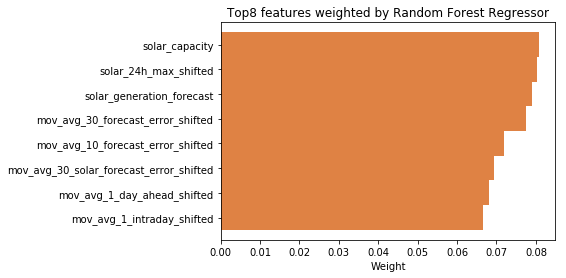

[(0.0666, 'mov_avg_1_intraday_shifted'),
 (0.0682, 'mov_avg_1_day_ahead_shifted'),
 (0.0693, 'mov_avg_30_solar_forecast_error_shifted'),
 (0.0719, 'mov_avg_10_forecast_error_shifted'),
 (0.0776, 'mov_avg_30_forecast_error_shifted'),
 (0.0789, 'solar_generation_forecast'),
 (0.0803, 'solar_24h_max_shifted'),
 (0.0809, 'solar_capacity')]

In [57]:
# See how important the features of the data frame are for the prediction with Random Forests

RFR = RandomForestRegressor(max_depth=25, n_estimators=100)
RFR.fit(X,y)
features = sorted(zip(map(lambda x: round(x, 4), RFR.feature_importances_), X.columns), reverse=True)
features = features[0:8]
features = features[::-1]
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.barh(xs, ys, width, align='center', color='#df8244')
plt.yticks(xs, labels) #rotation='vertical'
plt.title("Top8 features weighted by Random Forest Regressor")
plt.xlabel("Weight")
plt.show()
features

### Model 3: Ridge Regression

In [46]:
scores_list = []
param_range = (0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000)

for alpha in param_range:
    RR = Ridge(alpha=alpha)
    scores_list.append(cross_validate(RR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
0.1,0.0274,365.31,475505.2,115.585,0.0272
1.0,0.0274,365.31,475505.2,115.584,0.0272
10.0,0.0274,365.31,475505.1,115.572,0.0272
100.0,0.0274,365.30,475504.1,115.470,0.0272
1000.0,0.0274,365.15,475497.0,115.312,0.0272
10000.0,0.0274,364.26,475498.2,113.132,0.0272
100000.0,0.0267,361.75,475837.4,106.674,0.0265
1000000.0,0.0253,360.10,476518.8,101.538,0.0251
10000000.0,0.0245,358.83,476917.2,98.351,0.0242
100000000.0,0.0236,357.32,477381.1,94.382,0.0233


In [58]:
# Final Evaluation

RR = Ridge(alpha=1)
RR.fit(X_train, y_train)
y_pred = RR.predict(X_test)
r2_score(y_test, y_pred)

0.03710203632457243